# 2. A simple Physics-Informed Neural Network (with Feature Engineering)

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (28/09/2023)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.6.2)
- Numpy (tested on v1.23.5)
- Torch (tested on v1.12.1)
  
### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class LinearNN(nn.Module):
    def __init__(self, num_layers = 5, num_neurons = 128):
        # Start with attributes.
        super().__init__()
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        # Build layers.
        layers = []
        # First layer.
        layers.append(nn.Linear(2, self.num_neurons))
        # Hidden layers will consist of Linear layers and some activation.
        for _ in range(self.num_layers):
            layers.append(nn.Linear(self.num_neurons, self.num_neurons))
            layers.append(nn.ReLU())
        # Finish with one output layer, which is simply a linear and has no activation.
        layers.append(nn.Linear(self.num_neurons, 1))

        # Build the network as a Sequential object of the layers.
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Forward method made simple, using the Sequential object from earlier.
        return self.network(x).squeeze()

In [4]:
model = LinearNN().to(device)

In [5]:
# Parameters for the Physics problem
R_coeff = 0.1
X_0 = 0.0
T_0 = 100
T_env = 20

In [6]:
# Sigmoid function is actually the analytical solution to our PDE!
def sol_fun(x):
    return T_env + (T_0 - T_env)*np.exp(-R_coeff*x)

In [7]:
# Sigmoid function is actually the analytical solution to our PDE!
# (Torch version)
def sol_fun_torch(x):
    return T_env + (T_0 - T_env)*torch.exp(-R_coeff*x)

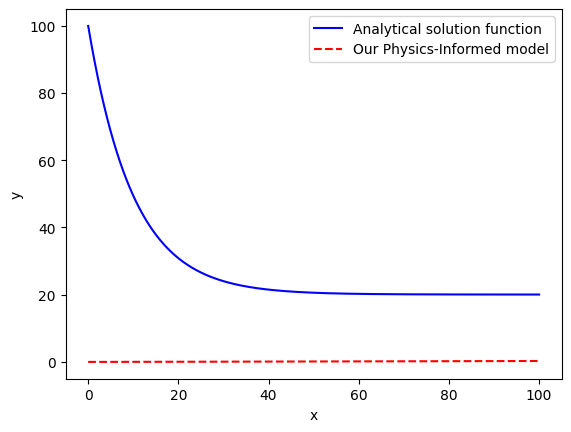

In [8]:
## Comparing model versus analytical solution
# Draw x using a linspace
x = torch.linspace(0, 100, steps = 1000).view(-1, 1).requires_grad_(True).to(device)
# Compute exp(-x)
exp_neg_x = torch.exp(-x)
# Concatenate x and exp(-x) to form the input tensor for the model
input_tensor = torch.cat((x, exp_neg_x), dim = 1)
# Detach and convert to numpy for matplotlib
xs = x.cpu().detach().numpy()
# Use model to predict on x
y = model(input_tensor)
# Detach and convert to numpy for matplotlib
ys = y.cpu().detach().numpy()

# Comparing model vs. analytical solution
plt.plot(xs, sol_fun(xs), "b-", label = "Analytical solution function")
plt.plot(xs, ys, "r--", label = "Our Physics-Informed model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc = "best")
plt.show()

In [9]:
# This function will compute gradients with respect to inputs,
# for the given forward pass that produced the respective outputs.
def grad_fun(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs = torch.ones_like(outputs), create_graph = True)

In [10]:
# This is the custom loss function we plan to use for the model
def physics_loss(model):
    # Generate x tensor by drawing with a linspace
    x = torch.linspace(0, 100, steps = 1000).view(-1, 1).requires_grad_(True).to(device)
    exp_neg_x = torch.exp(-x)
    input_tensor = torch.cat((x, exp_neg_x), dim = 1)

    # Forward pass
    y = model(input_tensor)
    # Compute the gradient manually
    dy = grad_fun(y, x)[0]
    
    # Compute the loss
    # Val1: checks if the model fits the PDE
    # Val2: checks if the model fits the initial condition
    # Lambda_coeffs: serves the same purpose as in regularization, to indicate
    # the importance of one aspect of the loss (e.g. val1) wrt. the second part (e.g. val2).
    # Note: technically, lambda_coeff is an hyperparameter
    # and we should investigate different values!
    right_hand_side_pde = (R_coeff*(T_env - y)).view(dy.shape)
    val1 = torch.mean((dy - right_hand_side_pde)**2)
    X_0 = torch.linspace(0, 0, steps = 1).view(-1, 1).requires_grad_(True).to(device)
    exp_neg_X_0 = torch.exp(-X_0)
    input_tensor_0 = torch.cat((X_0, exp_neg_X_0), dim=1)
    Y_0 = model(input_tensor_0)
    GT_0 = sol_fun_torch(X_0).view(Y_0.shape)
    val2 = torch.mean((Y_0 - GT_0)**2)
    lambda_coeff1 = 1
    lambda_coeff2 = 1
    # Return assembled loss value
    # Also returns val1 and val2 for visualization
    return 1 + lambda_coeff1*val1 + lambda_coeff2*val2, val1, val2

In [11]:
# Our loss has a certain value, which is not necessarily zero
# (This is normal, given that the model is untrained!)
model = LinearNN().to(device)
loss, val1, val2 = physics_loss(model)
print(loss)
print(val1)
print(val2)

tensor(10004.8770, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9999.8906, device='cuda:0', grad_fn=<MeanBackward0>)


In [12]:
# Choose parameters for the training, as before
num_iter = 3001
learning_rate = 1e-3

In [13]:
### Training loop
# Reset model
model = LinearNN().to(device)

# Choose an optimizer, let us be original (!) and use Adam
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Keep track of loss values
loss, val1, val2 = physics_loss(model)
loss_values = [loss.item()]
val1_values = [val1.item()]
val2_values = [val2.item()]

for i in range(num_iter):
    # Learning rate adjustment (using a decay based on iterations)
    decay = 1 + 10*i//1000
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate/decay)
    
    # Forward pass: Compute the loss
    loss, val1, val2 = physics_loss(model)
    
    # Zero the gradients
    optimizer.zero_grad()
    # Backward pass: Compute gradient of the loss with respect to model parameters
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    
    if i % 10 == 0:
        # Add to list every 10 iterations
        loss_values.append(loss.item())
        val1_values.append(val1.item())
        val2_values.append(val2.item())
        if i % 200 == 0:
            # Print progress every 200 iterations
            print(f"Iteration {i}, Combined Loss: {loss.item()}, PDE part: {val1.item()}, Init Cond. part: {val2.item()}")

Iteration 0, Combined Loss: 10004.2236328125, PDE part: 4.005288124084473, Init Cond. part: 9999.21875
Iteration 200, Combined Loss: 57.018001556396484, PDE part: 9.56823444366455, Init Cond. part: 46.44976806640625
Iteration 400, Combined Loss: 20.885072708129883, PDE part: 5.705198287963867, Init Cond. part: 14.179874420166016
Iteration 600, Combined Loss: 11.521856307983398, PDE part: 4.074359893798828, Init Cond. part: 6.4474968910217285
Iteration 800, Combined Loss: 7.9081621170043945, PDE part: 3.494018316268921, Init Cond. part: 3.4141438007354736
Iteration 1000, Combined Loss: 6.020610809326172, PDE part: 2.8660058975219727, Init Cond. part: 2.1546051502227783
Iteration 1200, Combined Loss: 4.750827789306641, PDE part: 2.3256099224090576, Init Cond. part: 1.425217628479004
Iteration 1400, Combined Loss: 3.9619698524475098, PDE part: 1.9495257139205933, Init Cond. part: 1.0124439001083374
Iteration 1600, Combined Loss: 3.3504152297973633, PDE part: 1.60683274269104, Init Cond. p

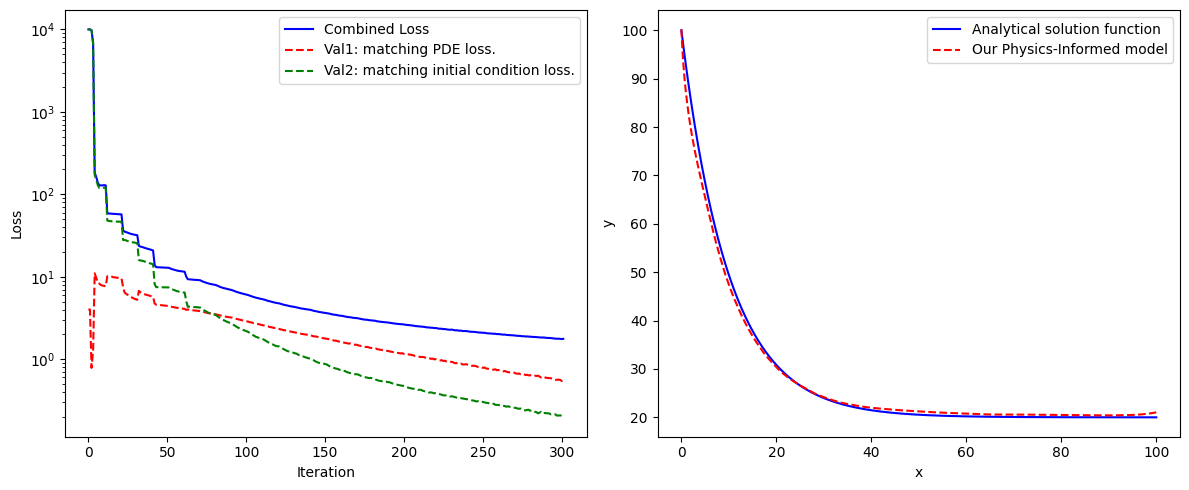

In [14]:
# First subplot: Training curves for loss
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1) 
plt.plot(loss_values, "b", label = "Combined Loss")
plt.plot(val1_values, "r--", label = "Val1: matching PDE loss.")
plt.plot(val2_values, "g--", label = "Val2: matching initial condition loss.")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc = "best")

## Comparing model versus analytical solution
# Draw x using a linspace
x = torch.linspace(0, 100, steps = 1000).view(-1, 1).requires_grad_(True).to(device)
# Compute exp(-x)
exp_neg_x = torch.exp(-x)
# Concatenate x and exp(-x) to form the input tensor for the model
input_tensor = torch.cat((x, exp_neg_x), dim = 1)
# Detach and convert to numpy for matplotlib
xs = x.cpu().detach().numpy()
# Use model to predict on x
y = model(input_tensor)
# Detach and convert to numpy for matplotlib
ys = y.cpu().detach().numpy()
# Second subplot: Comparing model vs. analytical solution
plt.subplot(1, 2, 2)
plt.plot(xs, sol_fun(xs), "b-", label = "Analytical solution function")
plt.plot(xs, ys, "r--", label = "Our Physics-Informed model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc = "best")

# Display the combined plots
plt.tight_layout()
plt.show()